In [1]:
%matplotlib inline
import pandas
import math
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from skimage.transform import hough_line, hough_line_peaks,probabilistic_hough_line
from skimage.feature import canny, corner_harris, corner_peaks
import skimage.io as io
import requests
from io import StringIO
import csv
import time

In [2]:
data = pandas.read_csv('../data/20151119---SAMPLE3-PHREE-100XMEOH-MOBILITY_dt_temp_Apex3DIons.csv')
m_z = data.m_z.tolist()
rt = data.rt.tolist()
inten = data.inten.tolist()

In [3]:
print('RT:','min:',min(rt),'max:',max(rt),'dynamic range:',max(rt)-min(rt))
print('m/z:','min:',min(m_z),'max:',max(m_z),'dynamic range:',max(m_z)-min(m_z))
print('intensity:','min:',min(inten),'max:',max(inten),'dynamic range:',max(inten)-min(inten),'deciles:',np.percentile(inten, 99))

RT: min: 1.5101 max: 197.4907 dynamic range: 195.9806
m/z: min: 50.0831 max: 999.9728 dynamic range: 949.8897
intensity: min: 10 max: 2121069 dynamic range: 2121059 deciles: 1576.62


In [4]:
RT_min=min(rt)
m_z_min=min(m_z)
data.inten=data.inten/min(inten)
inten = data.inten.tolist()

In [5]:
threshold=1000

(array([ 165.,   31.,    9.,    4.,    2.,    2.,    1.,    1.,    0.,    0.]),
 array([  1000.,   3900.,   6800.,   9700.,  12600.,  15500.,  18400.,
         21300.,  24200.,  27100.,  30000.]),
 <a list of 10 Patch objects>)

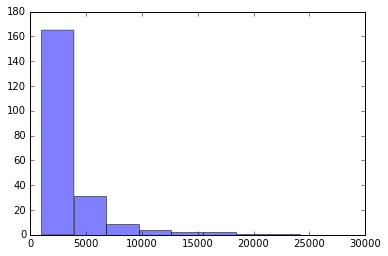

In [6]:
plt.hist(data.inten,alpha=0.5,cumulative=-1,range=(threshold,30000))

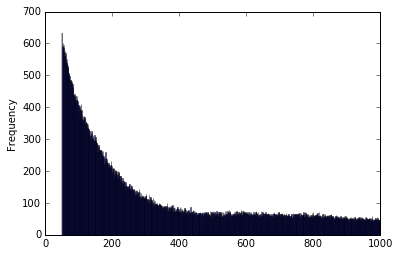

In [7]:
data.m_z.plot(kind='hist', alpha=0.5,bins=1000)

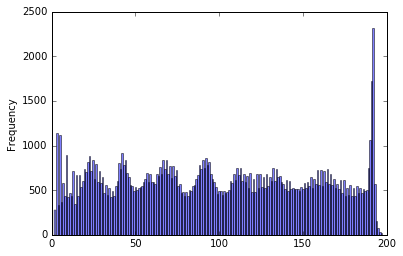

In [8]:
data.rt.plot(kind='hist', alpha=0.5,bins=200)

In [9]:
img=Image.new("F", (200,1000))

In [10]:
rt_step=(max(rt)-min(rt))/(200-1)
m_z_step=(max(m_z)-min(m_z))/(1000-1)

In [11]:
buffer = img.load()
filtered_peaks_list=[]
for peak in zip(rt,m_z,inten):
    if peak[2]>=threshold:
        buffer[int((peak[0]-min(rt))/rt_step),int((peak[1]-min(m_z))/m_z_step)]+=peak[2]
        filtered_peaks_list.append(peak)

In [12]:
### view image directly
# img.show()

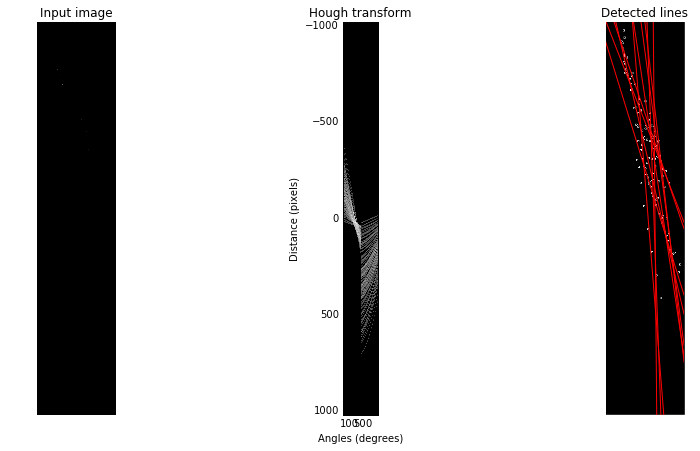

In [13]:
gray=np.array(img)
for i in range(1):
    #sci-kit image
    edges = canny(gray, 2, 1, 25)
    h, theta, d = hough_line(edges,theta=np.concatenate((np.linspace(-np.pi/4, 0, 90),np.linspace(np.pi/2, np.pi *3/4, 90))))
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))
    plt.tight_layout()
    # Generating figure 1.
    ax0.imshow(gray, cmap=cm.gray)
    ax0.set_title('Input image')
    ax0.set_axis_off()

    ax1.imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
    ax1.set_title('Hough transform')
    ax1.set_xlabel('Angles (degrees)')
    ax1.set_ylabel('Distance (pixels)')
    ax1.axis('image')
    
    ax2.imshow(edges, cmap=cm.gray)
    row1, col1 = gray.shape
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=9, min_angle=5, threshold=0.4 * np.max(h),num_peaks=10)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
        ax2.plot((0, col1), (y0, y1), '-r')

    ax2.axis((0, col1, row1, 0))
    ax2.set_title('Detected lines')
    ax2.set_axis_off()
    

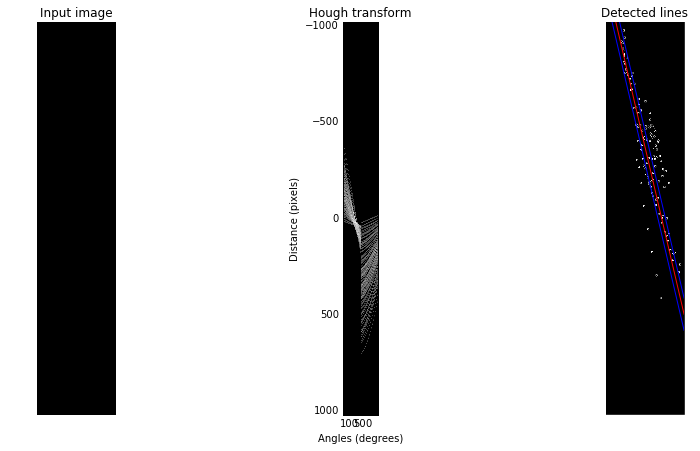

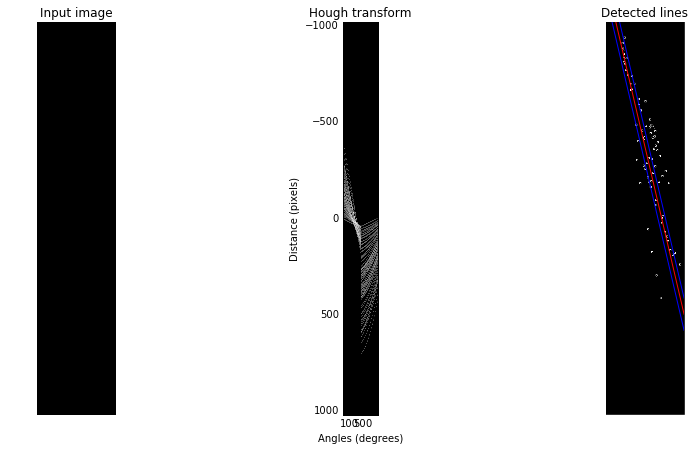

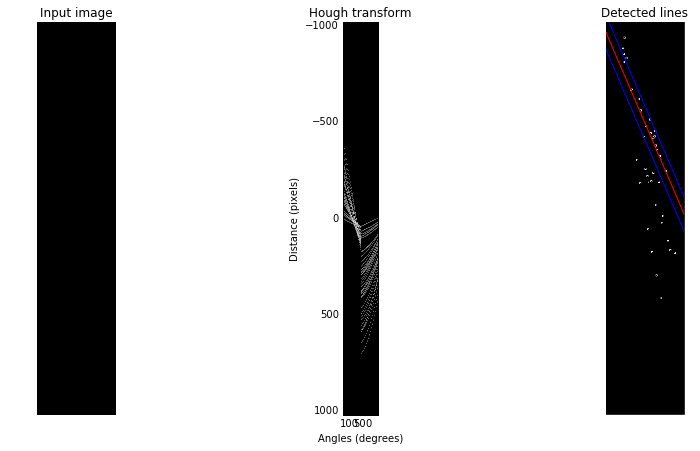

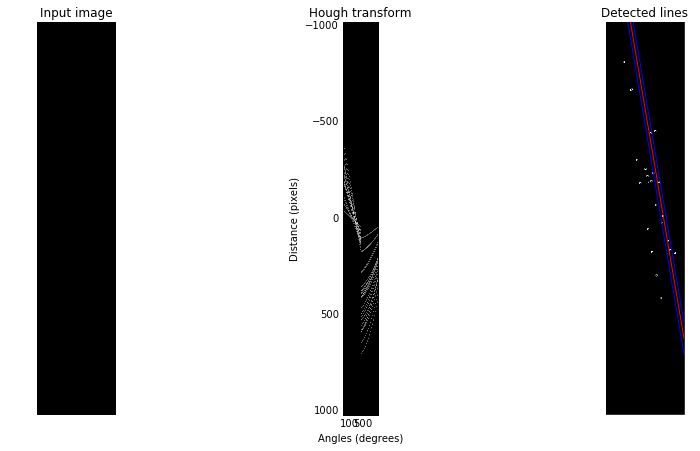

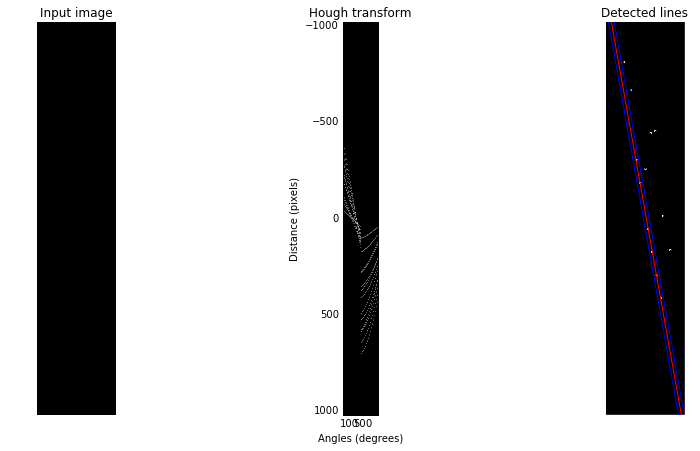

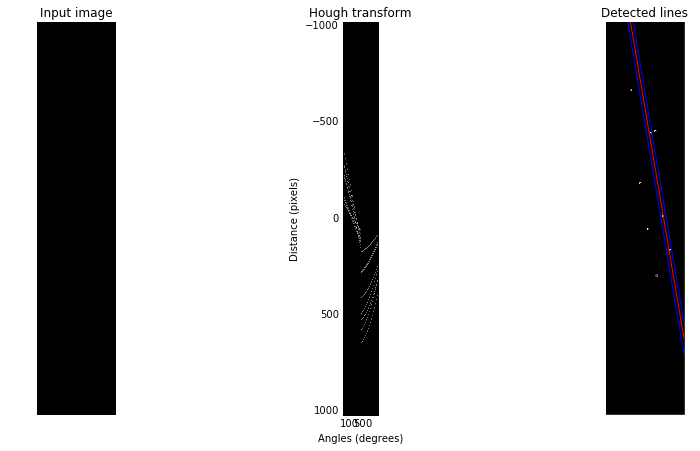

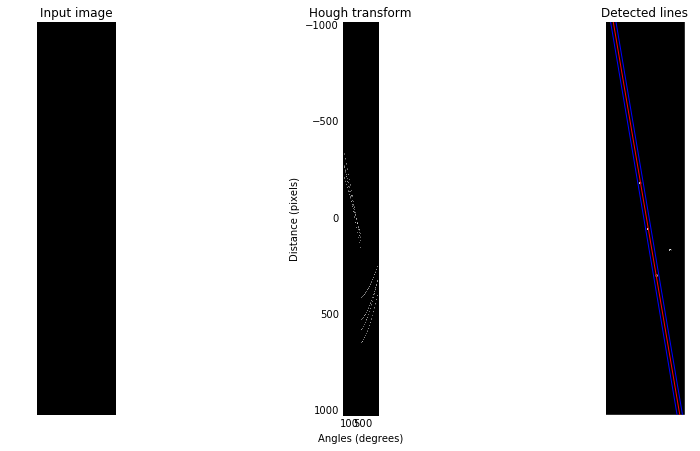

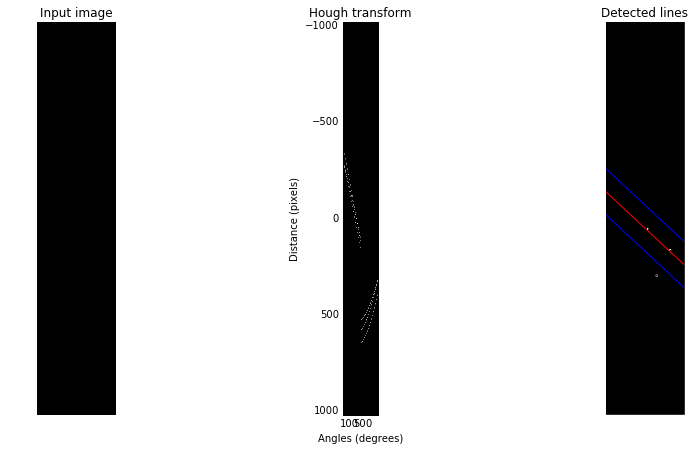

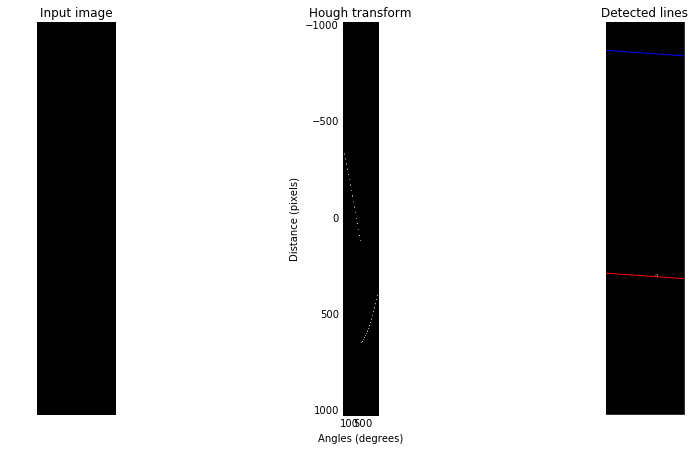

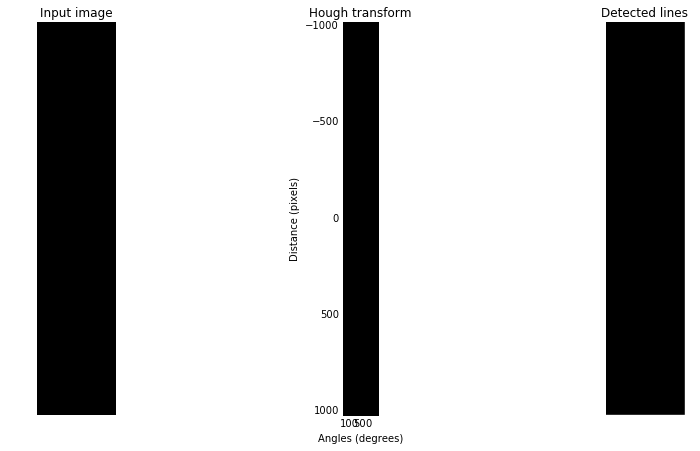

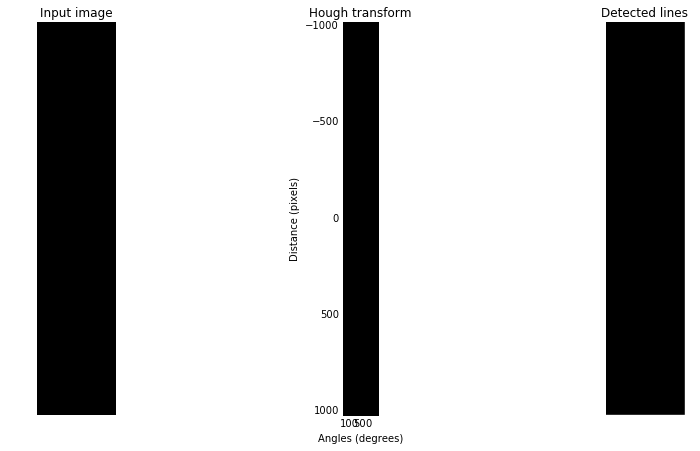

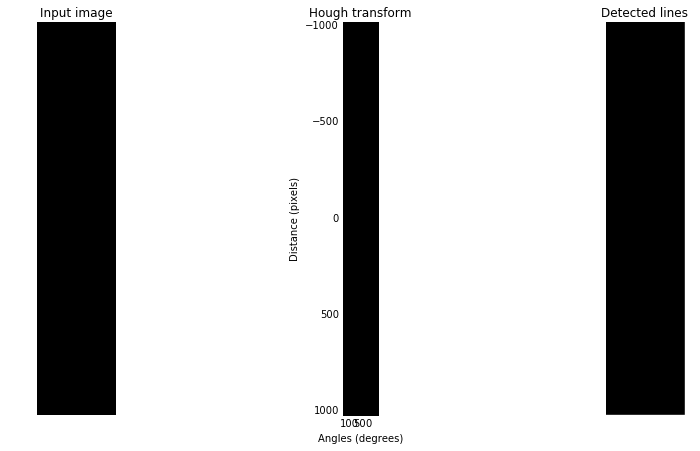

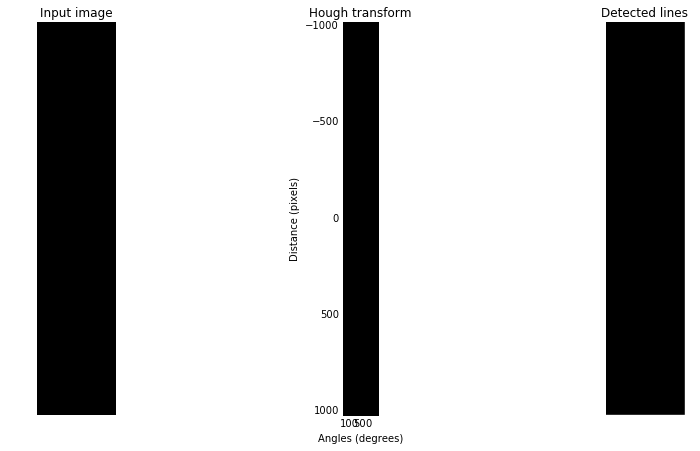

In [14]:
gray=np.array(img)
delta=40
extract_peaks_list=[]
for i in range(13):
    #sci-kit image
    edges = canny(gray, 2, 1, 25)
    h, theta, d = hough_line(edges,theta=np.concatenate((np.linspace(-np.pi/4, 0, 90),np.linspace(np.pi/2, np.pi *3/4, 90))))
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))
    plt.tight_layout()
    # Generating figure 1.
    ax0.imshow(gray, cmap=cm.gray)
    ax0.set_title('Input image')
    ax0.set_axis_off()

    ax1.imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
    ax1.set_title('Hough transform')
    ax1.set_xlabel('Angles (degrees)')
    ax1.set_ylabel('Distance (pixels)')
    ax1.axis('image')
    
    ax2.imshow(edges, cmap=cm.gray)
    row1, col1 = gray.shape
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=9, min_angle=10, threshold=0.5 * np.max(h),num_peaks=1)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
        ax2.plot((0, col1), (y0, y1), '-r')
        m=(y0-y1)/(0-col1)
#         print('angle=',angle,'m=',m,'d=',y0)
        ax2.plot((0, col1), (y0+delta/np.cos(angle), y1+delta/np.cos(angle)), '-b')
        ax2.plot((0, col1), (y0-delta/np.cos(angle), y1-delta/np.cos(angle)), '-b')
    ax2.axis((0, col1, row1, 0))
    ax2.set_title('Detected lines')
    ax2.set_axis_off()
    extract_peaks_list.append([])
    for peak in filtered_peaks_list:
        if ( - m * int((peak[0]-min(rt))/rt_step) + int((peak[1]-min(m_z))/m_z_step) - y0 ) ** 2  <= (delta ** 2) * (m ** 2 + 1) :
            gray[int((peak[1]-min(m_z))/m_z_step),int((peak[0]-min(rt))/rt_step)]=0
            extract_peaks_list[-1].append(peak)
            filtered_peaks_list.remove(peak)
#     print(np.nonzero(edges))

In [15]:
extract_m_z_list=[]
for i in range(len(extract_peaks_list)):
    extract_m_z_list.append([])
    for j in range(len(extract_peaks_list[i])):
        extract_m_z_list[i].append(extract_peaks_list[i][j][1])

In [16]:
ms_search={
    'utf8':'✓',
    'authenticity_token':'xibiDSCqq2oUXIvfouB2OdHnQRVbYHOm9hCnvuoWSlsbZWw/P224zByUZ5eqhIJWxQcRtXSwyrVdKZCHqe4s+Q==',
    'tolerance_units':'ppm',
    'mode':'positive',
    'adduct_type':'M+H M+Na M+K',
    'query_masses':'',
    'tolerance':'100','database':'HMDB',
    'commit':'Download',
    'Results':'',
    'As':'',
    'CSV':''
}
for i in range(len(extract_m_z_list)):
    ms_search['query_masses']=''
    for j in range(0,len(extract_m_z_list[i])-1):
        ms_search['query_masses']+=(str(extract_m_z_list[i][j])+' ')
    if len(extract_m_z_list[i])>=1:
        ms_search['query_masses']+=(str(str(extract_m_z_list[i][len(extract_m_z_list[i])-1])))
#         print(ms_search['query_masses'])
        while True:
            r = requests.post('http://specdb.wishartlab.com/ms/search.csv',data=ms_search)
            if r.status_code==200:
                break;
        f = StringIO(r.text)
        reader = csv.reader(f, delimiter=',')
        with open('../data/search_result/sample3/20151119---SAMPLE3-PHREE-100XMEOH-MOBILITY_dt_temp_Apex3DIons'+str(i+1)+'.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            for row in reader:
                writer.writerow(row)
            csvfile.close()